In [1]:
import numpy as np
from tensorflow import set_random_seed
from numpy.random import seed
import pandas as pd
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import datetime
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#dataset_empty = 0
set_random_seed(1)
seed(1)

In [3]:
#Convert the train data into time series
def time_series_data(data, window, lag):
    dropnan = True
    cols, names = list(), list()

    for i in range(window, 0, -1):
        #past time series data (t-)
        cols.append(data.shift(i))
        names = names + [('%s(t-%d)' % (col, i)) for col in data.columns]
    
    #current time series data (t = 0)
    cols.append(data)
    names = names + [('%s(t)' % (col)) for col in data.columns]
    
    #future data (t + lag)
    cols.append(data.shift(-lag))
    names = names + [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    #all data
    all_data = pd.concat(cols, axis=1)
    all_data.columns = names
    
    #drops rows with NaN
    if dropnan:
        all_data.dropna(inplace=True)
    return all_data

In [94]:
dataset = pd.read_csv('interest_over_time_s1_1_3.csv', usecols = ['Store', 'Item', 'Date', 'Weekly_Demand'])
train = dataset[['Store', 'Item', 'Date', 'Weekly_Demand']]
train = train.loc[(train['Store'] == 1) & (train['Item'] == 1)]
#train = train[(train['Date'] >= '2012-01-01')]
#train = train.loc[train['Store'] == 3]

print(train.head())

   Store  Item        Date  Weekly_Demand
0      1     1  2010-02-07             99
1      1     1  2010-02-14             54
2      1     1  2010-02-21            100
3      1     1  2010-02-28              0
4      1     1  2010-03-07             51


In [95]:
#Re-arranges the train dataset to apply shift methods
train_r = train.sort_values('Date').groupby(['Item', 'Store', 'Date'], as_index=False)
train_r = train_r.agg({'Weekly_Demand':['mean']})
train_r.columns = ['Item', 'Store', 'Date', 'Weekly_Demand']
#cols_to_drop = ['Date']
#train_r.drop(cols_to_drop, axis=1, inplace=True)
train_r.head()

,Item,Store,Date,Weekly_Demand
0,1,1,2010-02-07,99
1,1,1,2010-02-14,54
2,1,1,2010-02-21,100
3,1,1,2010-02-28,0
4,1,1,2010-03-07,51


In [96]:
#weekly demand in 0-10 scale
train_r['Weekly_Demand'] = train_r['Weekly_Demand'] / 10
train_r.head()

,Item,Store,Date,Weekly_Demand
0,1,1,2010-02-07,9.9
1,1,1,2010-02-14,5.4
2,1,1,2010-02-21,10.0
3,1,1,2010-02-28,0.0
4,1,1,2010-03-07,5.1


In [97]:
#the model will use last 117 weekly demand data and 
#current timestep (7 days) to forecast next weekly demand data 12 weeks ahead

window = 117
lag = 12

series_data = time_series_data(train_r, window, lag)
series_data.head()

,Item(t-117),Store(t-117),Date(t-117),Weekly_Demand(t-117),Item(t-116),Store(t-116),Date(t-116),Weekly_Demand(t-116),Item(t-115),Store(t-115),...,Date(t-1),Weekly_Demand(t-1),Item(t),Store(t),Date(t),Weekly_Demand(t),Item(t+12),Store(t+12),Date(t+12),Weekly_Demand(t+12)
117,1.0,1.0,2010-02-07,9.9,1.0,1.0,2010-02-14,5.4,1.0,1.0,...,2012-04-29,2.1,1,1,2012-05-06,2.1,1.0,1.0,2012-07-29,2.9
118,1.0,1.0,2010-02-14,5.4,1.0,1.0,2010-02-21,10.0,1.0,1.0,...,2012-05-06,2.1,1,1,2012-05-13,0.0,1.0,1.0,2012-08-05,3.3
119,1.0,1.0,2010-02-21,10.0,1.0,1.0,2010-02-28,0.0,1.0,1.0,...,2012-05-13,0.0,1,1,2012-05-20,3.2,1.0,1.0,2012-08-12,2.1
120,1.0,1.0,2010-02-28,0.0,1.0,1.0,2010-03-07,5.1,1.0,1.0,...,2012-05-20,3.2,1,1,2012-05-27,2.1,1.0,1.0,2012-08-19,2.0
121,1.0,1.0,2010-03-07,5.1,1.0,1.0,2010-03-14,0.0,1.0,1.0,...,2012-05-27,2.1,1,1,2012-06-03,2.1,1.0,1.0,2012-08-26,2.9


In [98]:
future_dates = series_data[['Date(t+%d)' % lag]]
future_dates

,Date(t+12)
117,2012-07-29
118,2012-08-05
119,2012-08-12
120,2012-08-19
121,2012-08-26
122,2012-09-02
123,2012-09-09
124,2012-09-16
125,2012-09-23
126,2012-09-30


In [99]:
#drops last record of (t + lag)
#last_record_item = 'Item(t-%d)' % window
#last_record_store = 'Store(t-%d)' % window
#series_data = series_data[(series_data['Item(t)'] == series_data[last_record_item])]
#series_data = series_data[(series_data['Store(t)'] == series_data[last_record_store])]

#drops Item and Store columns
#cols_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Item', 'Store', 'Date']]
#for i in range(window, 0, -1):
#    cols_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Item', 'Store', 'Date']]

#series_data.drop(cols_to_drop, axis=1, inplace=True)
#series_data.drop(['Item(t)', 'Store(t)', 'Date(t)'], axis=1, inplace=True)

cols_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Date']]
for i in range(window, 0, -1):
    cols_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Date']]

series_data.drop(cols_to_drop, axis=1, inplace=True)
series_data.drop(['Date(t)'], axis=1, inplace=True)

lbls_col = 'Weekly_Demand(t+%d)' % lag
lbls = series_data[lbls_col]
series_data = series_data.drop(lbls_col, axis=1)

series_data.head()

,Item(t-117),Store(t-117),Weekly_Demand(t-117),Item(t-116),Store(t-116),Weekly_Demand(t-116),Item(t-115),Store(t-115),Weekly_Demand(t-115),Item(t-114),...,Store(t-2),Weekly_Demand(t-2),Item(t-1),Store(t-1),Weekly_Demand(t-1),Item(t),Store(t),Weekly_Demand(t),Item(t+12),Store(t+12)
117,1.0,1.0,9.9,1.0,1.0,5.4,1.0,1.0,10.0,1.0,...,1.0,5.0,1.0,1.0,2.1,1,1,2.1,1.0,1.0
118,1.0,1.0,5.4,1.0,1.0,10.0,1.0,1.0,0.0,1.0,...,1.0,2.1,1.0,1.0,2.1,1,1,0.0,1.0,1.0
119,1.0,1.0,10.0,1.0,1.0,0.0,1.0,1.0,5.1,1.0,...,1.0,2.1,1.0,1.0,0.0,1,1,3.2,1.0,1.0
120,1.0,1.0,0.0,1.0,1.0,5.1,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,3.2,1,1,2.1,1.0,1.0
121,1.0,1.0,5.1,1.0,1.0,0.0,1.0,1.0,5.0,1.0,...,1.0,3.2,1.0,1.0,2.1,1,1,2.1,1.0,1.0


In [100]:
#train and test split

X_train, X_test, Y_train, Y_test = train_test_split(series_data, lbls.values, test_size=0.9, random_state=0, shuffle=False)
X_test = series_data
#print('Train dataset:', X_train.shape)
print('Test dataset:', X_test.shape)
X_test

Test dataset: (14, 356)


,Item(t-117),Store(t-117),Weekly_Demand(t-117),Item(t-116),Store(t-116),Weekly_Demand(t-116),Item(t-115),Store(t-115),Weekly_Demand(t-115),Item(t-114),...,Store(t-2),Weekly_Demand(t-2),Item(t-1),Store(t-1),Weekly_Demand(t-1),Item(t),Store(t),Weekly_Demand(t),Item(t+12),Store(t+12)
117,1.0,1.0,9.9,1.0,1.0,5.4,1.0,1.0,10.0,1.0,...,1.0,5.0,1.0,1.0,2.1,1,1,2.1,1.0,1.0
118,1.0,1.0,5.4,1.0,1.0,10.0,1.0,1.0,0.0,1.0,...,1.0,2.1,1.0,1.0,2.1,1,1,0.0,1.0,1.0
119,1.0,1.0,10.0,1.0,1.0,0.0,1.0,1.0,5.1,1.0,...,1.0,2.1,1.0,1.0,0.0,1,1,3.2,1.0,1.0
120,1.0,1.0,0.0,1.0,1.0,5.1,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,3.2,1,1,2.1,1.0,1.0
121,1.0,1.0,5.1,1.0,1.0,0.0,1.0,1.0,5.0,1.0,...,1.0,3.2,1.0,1.0,2.1,1,1,2.1,1.0,1.0
122,1.0,1.0,0.0,1.0,1.0,5.0,1.0,1.0,5.6,1.0,...,1.0,2.1,1.0,1.0,2.1,1,1,2.9,1.0,1.0
123,1.0,1.0,5.0,1.0,1.0,5.6,1.0,1.0,5.2,1.0,...,1.0,2.1,1.0,1.0,2.9,1,1,1.9,1.0,1.0
124,1.0,1.0,5.6,1.0,1.0,5.2,1.0,1.0,4.9,1.0,...,1.0,2.9,1.0,1.0,1.9,1,1,3.1,1.0,1.0
125,1.0,1.0,5.2,1.0,1.0,4.9,1.0,1.0,5.1,1.0,...,1.0,1.9,1.0,1.0,3.1,1,1,2.2,1.0,1.0
126,1.0,1.0,4.9,1.0,1.0,5.1,1.0,1.0,0.0,1.0,...,1.0,3.1,1.0,1.0,2.2,1,1,2.2,1.0,1.0


In [101]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
#print('Train dataset:', X_train_series.shape)
print('Test dataset:', X_test_series.shape)

Test dataset: (14, 356, 1)


In [102]:
#CNN-LSTM
subsequences = 2
time_steps = X_test_series.shape[1] // subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, time_steps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, time_steps, 1))
#print('Train dataset:', X_train_series_sub.shape)
print('Test dataset:', X_test_series_sub.shape)

Test dataset: (14, 2, 178, 1)


In [103]:
epochs = 5000
batch = 32
learning_rate = 0.00000001
adam = optimizers.Adam(learning_rate)

In [104]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 1, activation = 'relu'), input_shape = (None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(60, activation = 'relu'))
model_cnn_lstm.add(Dropout(0.5))
model_cnn_lstm.add(Dense(30, activation = 'relu'))
model_cnn_lstm.add(Dropout(0.5))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss = 'mse', optimizer = 'adam')
model_cnn_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, None, 178, 64)     128       
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 89, 64)      0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, None, 5696)        0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60)                1381680   
_________________________________________________________________
dropout_13 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)                1830      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
__________

In [105]:
#load from saved file
file_name = "cnn_lstm_gtrends_weights_s1_i1.hdf5"

model_cnn_lstm.load_weights(file_name)
model_cnn_lstm.compile(loss = 'mse', optimizer = 'adam')

#prediction
#cnn_lstm_train_prediction = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_test_prediction = model_cnn_lstm.predict(X_test_series_sub)

test_p = []
for i in range(0, cnn_lstm_test_prediction.shape[0]):
    test_p.append(round(cnn_lstm_test_prediction[i][0], 2))

test_p

[2.87,
 3.12,
 2.15,
 2.14,
 2.79,
 3.58,
 2.51,
 2.8,
 2.55,
 2.13,
 2.13,
 2.05,
 4.09,
 3.39]

In [106]:
predictions = pd.DataFrame({'Item' : 1,
                            'Store' : 1,
                            'Date' : list(future_dates['Date(t+12)']),
                            'Weekly_Demand' : test_p})
predictions

,Item,Store,Date,Weekly_Demand
0,1,1,2012-07-29,2.87
1,1,1,2012-08-05,3.12
2,1,1,2012-08-12,2.15
3,1,1,2012-08-19,2.14
4,1,1,2012-08-26,2.79
5,1,1,2012-09-02,3.58
6,1,1,2012-09-09,2.51
7,1,1,2012-09-16,2.80
8,1,1,2012-09-23,2.55
9,1,1,2012-09-30,2.13


In [107]:
train_p = train_r
actual_data = train_p.tail(117 + 12)
#train_p.drop(['Item', 'Store'], axis=1, inplace=True)
#actual_data.drop(['Item', 'Store'], axis=1, inplace=True)
window = 117
lag = 12

for k in range(0, 12):
    X_test_predict = train_p.tail(117 + 12)    
    max_date = X_test_predict['Date'].max()
    next_date = datetime.datetime.strptime(max_date, '%Y-%m-%d').date() + timedelta(days=7)
    df = pd.DataFrame({'Item' : 1,
                       'Store' : 1,
                       'Date' : next_date.strftime("%Y-%m-%d"), 
                       'Weekly_Demand' : [0]})
    X_test_predict = X_test_predict.append(df)
    train_p = train_p.append(df)
    predictions = predictions.append(df)
    actual_data = actual_data.append(df)
    
    X_test_predict = X_test_predict.reset_index(drop = True)
    train_p = train_p.reset_index(drop = True)
    predictions = predictions.reset_index(drop = True)
    actual_data = actual_data.reset_index(drop = True)
        
    series_data_p = time_series_data(X_test_predict, window, lag)

    cols_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Date']]
    for i in range(window, 0, -1):
        cols_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Date']]

    series_data_p.drop(cols_to_drop, axis=1, inplace=True)
    series_data_p.drop(['Date(t)'], axis=1, inplace=True)

    lbls_col = 'Weekly_Demand(t+%d)' % lag
    lbls = series_data_p[lbls_col]
    series_data_p = series_data_p.drop(lbls_col, axis=1)

    X_test_series_p = series_data_p.values.reshape((series_data_p.shape[0], X_test.shape[1], 1))

    subsequences = 2
    time_steps_p = X_test_series_p.shape[1] // subsequences
    X_test_series_sub_p = X_test_series_p.reshape((X_test_series_p.shape[0], subsequences, time_steps_p, 1))   
    
    cnn_lstm_test_prediction = model_cnn_lstm.predict(X_test_series_sub_p)
    
    train_p.loc[(train_p['Date'] == next_date.strftime("%Y-%m-%d"))  & (train_p['Weekly_Demand'] == 0), ['Weekly_Demand']] = round(cnn_lstm_test_prediction[0][0], 2)
    predictions.loc[(predictions['Date'] == next_date.strftime("%Y-%m-%d")) & (predictions['Weekly_Demand'] == 0), ['Weekly_Demand']] = round(cnn_lstm_test_prediction[0][0], 2)
    
predictions

,Item,Store,Date,Weekly_Demand
0,1,1,2012-07-29,2.87
1,1,1,2012-08-05,3.12
2,1,1,2012-08-12,2.15
3,1,1,2012-08-19,2.14
4,1,1,2012-08-26,2.79
5,1,1,2012-09-02,3.58
6,1,1,2012-09-09,2.51
7,1,1,2012-09-16,2.80
8,1,1,2012-09-23,2.55
9,1,1,2012-09-30,2.13


In [108]:
predictions.drop(['Item', 'Store'], axis=1, inplace=True)
actual_data.drop(['Item', 'Store'], axis=1, inplace=True)

In [109]:
graph_data = actual_data.merge(predictions, left_on = ['Date'], 
                              right_on = ['Date'], how = 'outer')
graph_data = graph_data.loc[graph_data['Date'] >= '2012-07-29']
graph_data.loc[graph_data['Weekly_Demand_x'] == 0, ['Weekly_Demand_x']] = np.nan #Weekly_Sales_x is actual data and Weekly_Sales_y is the predicted data
graph_data

,Date,Weekly_Demand_x,Weekly_Demand_y
115,2012-07-29,2.9,2.87
116,2012-08-05,3.3,3.12
117,2012-08-12,2.1,2.15
118,2012-08-19,2.0,2.14
119,2012-08-26,2.9,2.79
120,2012-09-02,3.8,3.58
121,2012-09-09,4.3,2.51
122,2012-09-16,2.9,2.80
123,2012-09-23,NaN,2.55
124,2012-09-30,1.9,2.13


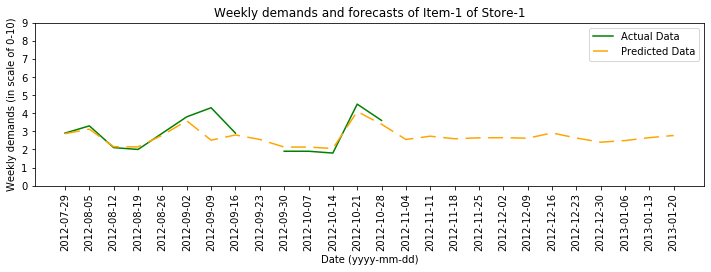

<Figure size 432x288 with 0 Axes>

In [110]:
plt.subplots(figsize=(12, 3))
plt.plot(graph_data.Date, graph_data.Weekly_Demand_x, color='green')
plt.plot(graph_data.Date, graph_data.Weekly_Demand_y, dashes=[10, 5, 10, 5], color='orange')
plt.legend(['Actual Data', 'Predicted Data'], loc='upper right')
plt.yticks(np.arange(0, 10, 1))
plt.xticks(graph_data.Date, rotation=90)
plt.title('Weekly demands and forecasts of Item-1 of Store-1')
plt.xlabel('Date (yyyy-mm-dd)')
plt.ylabel('Weekly demands (in scale of 0-10)')

plt.show()
plt.savefig('images\Weekly demands and forecasts of Item-1 of Store-1.png', bbox_inches='tight')